In [96]:
import numpy as np 
import matplotlib.pyplot as plt 

from keras.datasets import mnist

from keras.models import Sequential, Model

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D

from keras.optimizers import Adam

## create generator 
generator_ = Sequential([
    Dense(128 * 7 * 7, activation="relu", input_shape=(100,)), 
    Reshape((7, 7, 128)), 
    
    BatchNormalization(momentum=0.8), # what is batch normalization?? 
    UpSampling2D(), # what is upsampling?? 
    Conv2D(128, kernel_size=3, padding="same"),
    Activation("relu"), 
    
    BatchNormalization(momentum=0.8), 
    UpSampling2D(), 
    Conv2D(64, kernel_size=3, padding="same"), 
    Activation("relu"), 
    
    BatchNormalization(momentum=0.8), 
    Conv2D(1, kernel_size=3, padding="same"), 
    Activation("tanh"), 
])

noise_input = Input(shape=(100,), name="noise_input")
generator = Model(noise_input, generator_(noise_input), name="generator")

generator_.summary()# summary가 매우 유용하군요. 

optimizer = Adam(0.0002, 0.5)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_9 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d_17 (UpSampling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
activation_24 (Activation)   (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 14, 14, 128)       512       
__________

In [97]:
### create discriminator
discriminator_ = Sequential([
    Conv2D(32, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding="same"), 
    LeakyReLU(alpha=0.2), 
    Dropout(0.25), 
    
    Conv2D(64, kernel_size=3, strides=2, padding="same"), 
    ZeroPadding2D(padding=((0,1),(0,1))), 
    LeakyReLU(alpha=0.2), 
    Dropout(0.25), 
    BatchNormalization(momentum=0.8), 
    
    Conv2D(128, kernel_size=3, strides=2, padding="same"), 
    LeakyReLU(alpha=0.2), 
    Dropout(0.25), 
    BatchNormalization(momentum=0.8), 
    
    Conv2D(256, kernel_size=3, strides=1, padding="same"), 
    LeakyReLU(alpha=0.2), 
    Dropout(0.25), 
    Flatten(), 
    Dense(1, activation='sigmoid'), 
])
image_input = Input(shape=(28, 28, 1), name="image_input")

discriminator = Model(image_input, discriminator_(image_input), name="discriminator")
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
discriminator_.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 8, 8, 64)          0         
__________

In [98]:
### Combined Model
noise_input2 = Input(shape=(100,), name="noise_input2")
"""
model과 sequential의 차이는?? 
가설1: 레이어를 쌓는 것이 sequential 이라면, sequential을 쌓는 것이 model인가???

1) 다음 모델의 경우는 랜덤으로 만든 이미지로부터 학습해서 새로운 이미지를 만들어내는 generator의 데이터를 
2) discriminator가 분류하는 형식으로 진행된다. 
"""
combined = Model(noise_input2, discriminator(generator(noise_input2)))
combined.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [99]:
## read image
(X_train, _), (_, _) = mnist.load_data()
# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

In [100]:
#noise_data = np.random.normal(0, 1, (32, 100))
#generated_images = 0.5 * generator.predict(np.random.normal(0, 1, (32, 100))) + 0.5

def show_images(generated_images, n=4, m=8, figsize=(9, 5)):
    f, axes = plt.subplots(n, m, figsize=figsize)
    #plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
    for i in range(0, n):
        for j in range(0, m):
            ax = axes[i][j]
            ax.imshow(generated_images[i * m + j][:, :, 0], cmap=plt.cm.bone)
            ax.grid(False)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
    plt.tight_layout()
    plt.savefig('../../assets/images/markdown_img/180621_1554_gan_digit_img.svg')
    plt.show()   
#show_images(0.5 * generator.predict(np.random.normal(0, 1, (32, 100))) + 0.5)

    0 [D loss: 0.824, acc.: 50.39%] [G loss: 0.639, acc.: 64.84%]
   10 [D loss: 0.050, acc.: 99.61%] [G loss: 0.007, acc.: 100.00%]
   20 [D loss: 0.389, acc.: 82.42%] [G loss: 0.004, acc.: 100.00%]
   30 [D loss: 2.457, acc.: 47.27%] [G loss: 0.229, acc.: 96.48%]
   40 [D loss: 2.456, acc.: 49.61%] [G loss: 0.218, acc.: 98.44%]
   50 [D loss: 2.250, acc.: 50.00%] [G loss: 0.202, acc.: 100.00%]
   60 [D loss: 2.086, acc.: 50.00%] [G loss: 0.196, acc.: 100.00%]
   70 [D loss: 2.074, acc.: 50.00%] [G loss: 0.196, acc.: 100.00%]
   80 [D loss: 1.972, acc.: 50.00%] [G loss: 0.191, acc.: 99.61%]
   90 [D loss: 1.890, acc.: 50.00%] [G loss: 0.200, acc.: 100.00%]


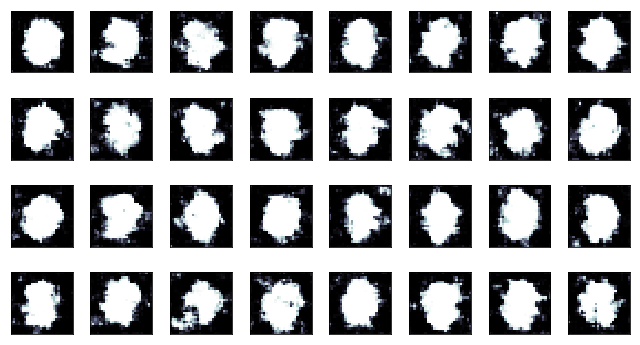

In [101]:
## training
"""
- 이 코드에서는 fit을 사용한 것이 아니라, train_on_batch를 사용했음. 
- train_on_batch와의 차이점?을 구글에 검색해보니, 큰 차이가 없다고 하긴 하는데
    - train_on_batch의 경우, 넘겨 받은 데이터에 대해서 gradient vector를 계산해서 적용하고 끝내는 것이고(1epoch)
    - fit의 경우는 epoch과 batch_size를 한번에 모두 넘겨준다는 것 정도가 차이가 된다. 
- GAN의 경우, discriminator의 학습시 마다 generator가 생성하는 데이터가 변화하게 된다. 
    - 즉 처음부터 모든 데이터가 존재하고 이를 한번에 학습시키는 fit과는 다르게, 한번씩 업데이트를 할때마다 모델이 변화하므로, 
    - train_on_batch를 사용하는 것이 매우 합당함.
"""
batch_size = 256
half_batch = batch_size // 2

def train(epochs, print_step=10):
    history = []
    for epoch in range(epochs):
        # discriminator 트레이닝 단계
        #######################################################################3
        # 데이터 절반은 실제 이미지, 절반은 generator가 생성한 가짜 이미지
        # discriminator가 실제 이미지와 가짜 이미지를 구별하도록 discriminator를 트레이닝
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(X_train[np.random.randint(0, X_train.shape[0], half_batch)], 
                                                   np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(generator.predict(np.random.normal(0, 1, (half_batch, 100))), 
                                                   np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        # generator 트레이닝 단계
        #######################################################################3
        # 전부 generator가 생성한 가짜 이미지를 사용. 
        # discriminator가 구별하지 못하도록 generator를 트레이닝
        
        """
        generator를 트레이닝할 때는, 반드시 discriminator가 필요함. 
        generator가 만든 image를 평가해야 하고, 그래야 feedback이 생겨서 generator가 학습됨. 
        따라서, generator는 combined model을 통해 학습시키는데, 이때, discriminator도 함께 학습되면 안되기 때문에
        discriminator.trainable 을 False로 변경시켜 둔다. 
        """
        noise = np.random.normal(0, 1, (batch_size, 100))
        discriminator.trainable = False 
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))
        # 기록
        record = (epoch, d_loss[0], 100 * d_loss[1], g_loss[0], 100 * g_loss[1])
        history.append(record)
        if epoch % print_step == 0:
            print("%5d [D loss: %.3f, acc.: %.2f%%] [G loss: %.3f, acc.: %.2f%%]" % record)
    return history
#%%time, 은
history100 = train(100, 10)
show_images(0.5 * generator.predict(noise_data) + 0.5)

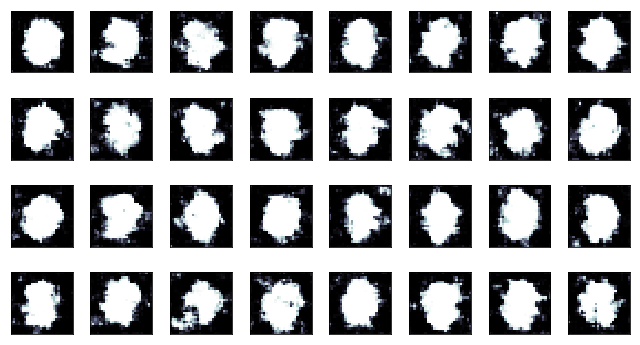

In [102]:
show_images(generator.predict(noise_data))

In [104]:
combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise_input2 (InputLayer)    (None, 100)               0         
_________________________________________________________________
generator (Model)            (None, 28, 28, 1)         856705    
_________________________________________________________________
discriminator (Model)        (None, 1)                 392705    
Total params: 1,249,410
Trainable params: 856,065
Non-trainable params: 393,345
_________________________________________________________________


In [ ]:
## training
"""
- 이 코드에서는 fit을 사용한 것이 아니라, train_on_batch를 사용했음. 
- train_on_batch와의 차이점?을 구글에 검색해보니, 큰 차이가 없다고 하긴 하는데
    - train_on_batch의 경우, 넘겨 받은 데이터에 대해서 gradient vector를 계산해서 적용하고 끝내는 것이고(1epoch)
    - fit의 경우는 epoch과 batch_size를 한번에 모두 넘겨준다는 것 정도가 차이가 된다. 
- GAN의 경우, discriminator의 학습시 마다 generator가 생성하는 데이터가 변화하게 된다. 
    - 즉 처음부터 모든 데이터가 존재하고 이를 한번에 학습시키는 fit과는 다르게, 한번씩 업데이트를 할때마다 모델이 변화하므로, 
    - train_on_batch를 사용하는 것이 매우 합당함.
"""
batch_size = 256
half_batch = batch_size // 2

def train(epochs, print_step=10):
    history = []
    for epoch in range(epochs):
        # discriminator 트레이닝 단계
        #######################################################################3
        # 데이터 절반은 실제 이미지, 절반은 generator가 생성한 가짜 이미지
        # discriminator가 실제 이미지와 가짜 이미지를 구별하도록 discriminator를 트레이닝
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(X_train[np.random.randint(0, X_train.shape[0], half_batch)], 
                                                   np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(generator.predict(np.random.normal(0, 1, (half_batch, 100))), 
                                                   np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        # generator 트레이닝 단계
        #######################################################################3
        # 전부 generator가 생성한 가짜 이미지를 사용. 
        # discriminator가 구별하지 못하도록 generator를 트레이닝
        
        """
        generator를 트레이닝할 때는, 반드시 discriminator가 필요함. 
        generator가 만든 image를 평가해야 하고, 그래야 feedback이 생겨서 generator가 학습됨. 
        따라서, generator는 combined model을 통해 학습시키는데, 이때, discriminator도 함께 학습되면 안되기 때문에
        discriminator.trainable 을 False로 변경시켜 둔다. 
        """
        noise = np.random.normal(0, 1, (batch_size, 100))
        discriminator.trainable = False 
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))
        # 기록
        record = (epoch, d_loss[0], 100 * d_loss[1], g_loss[0], 100 * g_loss[1])
        history.append(record)
        if epoch % print_step == 0:
            print("%5d [D loss: %.3f, acc.: %.2f%%] [G loss: %.3f, acc.: %.2f%%]" % record)
    return history
#%%time, 은
history100 = train(500, 10)
show_images(0.5 * generator.predict(noise_data) + 0.5)

    0 [D loss: 1.862, acc.: 50.00%] [G loss: 0.205, acc.: 100.00%]
   10 [D loss: 1.880, acc.: 50.00%] [G loss: 0.191, acc.: 100.00%]
   20 [D loss: 1.763, acc.: 50.00%] [G loss: 0.218, acc.: 100.00%]
   30 [D loss: 1.794, acc.: 50.00%] [G loss: 0.209, acc.: 100.00%]
   40 [D loss: 1.817, acc.: 50.00%] [G loss: 0.194, acc.: 100.00%]
   50 [D loss: 1.768, acc.: 50.00%] [G loss: 0.205, acc.: 100.00%]
   60 [D loss: 1.715, acc.: 50.00%] [G loss: 0.214, acc.: 100.00%]
   70 [D loss: 1.712, acc.: 50.00%] [G loss: 0.212, acc.: 100.00%]
   80 [D loss: 1.665, acc.: 50.00%] [G loss: 0.217, acc.: 100.00%]
   90 [D loss: 1.678, acc.: 50.00%] [G loss: 0.216, acc.: 99.61%]
  100 [D loss: 1.654, acc.: 50.00%] [G loss: 0.203, acc.: 100.00%]
  110 [D loss: 1.586, acc.: 50.00%] [G loss: 0.206, acc.: 100.00%]
  120 [D loss: 1.626, acc.: 50.00%] [G loss: 0.196, acc.: 100.00%]
  130 [D loss: 1.557, acc.: 50.00%] [G loss: 0.206, acc.: 100.00%]
  140 [D loss: 1.523, acc.: 50.00%] [G loss: 0.205, acc.: 100.0